# Session 05 - Policy Gradients - Assignment

In this assignment you will implement REINFORCE, a policy gradient method based on Monte Carlo sampling.
The key idea underlying policy gradients is to push up the probabilities of actions that lead to higher return, and push down the probabilities of actions that lead to lower return, until you arrive at the optimal policy.

The REINFORCE algorithm comprises the following steps:
0. Initialize and reset the environment.
1. Get the state from the environment.
2. Feed forward our policy network to predict the probability of each action we should take. We’ll sample from this distribution to choose which action to take (i.e. toss a biased coin). This implies that the ouput layer of the neural network has a Softmax activation function.
3. Receive the reward and the next state state from the environment for the action we took.
4. Store this transition sequence of state, action, reward, for later training.
5. Repeat steps 1–4. If we receive the done flag from the game it means the episode is over.
6. Once the episode is over, we train our neural network to learn from our stored transitions using our gradient update rule. After training you can clear the stored states, actions and rewards from the memory. 
7. Play next episode and repeat steps above until convergence

In [6]:
import gymnasium as gym
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy

from keras_sequential_ascii import keras2ascii

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.get_logger().setLevel('ERROR')

In [14]:
class MEMORY:
  def __init__(self, action_shape):
    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]
    self.action_shape = action_shape

  def hot_encode_action(self, action):
    action_encoded=np.zeros(self.action_shape)
    action_encoded[action]=1
    return action_encoded

  def remember(self, state, action, action_prob, reward):
    encoded_action=self.hot_encode_action(action)
    self.gradients.append(encoded_action-action_prob)
    self.states.append(state)
    self.rewards.append(reward)
    self.probs.append(action_prob)

  def clearMemory(self):
    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]

class REINFORCE:
  def __init__(self, env, path=None):
    self.env=env
    self.state_shape=env.observation_space.shape # the state space
    self.action_shape=env.action_space.n # the action space
    self.memory = MEMORY(self.action_shape) # init memory
    self.gamma=0.99 # decay rate of past observations
    self.alpha=1e-4 # learning rate of gradient
    self.learning_rate=0.001 # learning of deep learning model
    self.discounted_rewards=[]
    self.total_rewards=[]

    if not path:
      self.model=self.build_policy_network() #build model
    else:
      self.model=self.load_model(path) #import model
    
  def build_policy_network(self):
    model=Sequential()
    model.add(Dense(64, input_shape=self.state_shape, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(self.action_shape, activation="softmax")) 
    model.compile(loss="categorical_crossentropy",
            optimizer=Adam(learning_rate=self.learning_rate))
    keras2ascii(model)   
    return model
  
  def compute_action(self, state):
    # transform state
    state=state.reshape([1, state.shape[0]])

    # get action probably
    action_probability_distribution=self.model.predict(state, verbose=0).flatten()

    # norm action probability distribution
    action_probability_distribution /= np.sum(action_probability_distribution)
    
    # sample action
    action=np.random.choice(self.action_shape,1,
                            p=action_probability_distribution)[0]

    return action, action_probability_distribution


  def get_discounted_rewards(self, rewards): 
    discounted_rewards=[]
    cumulative_total_return=0
    # iterate the rewards backwards and and calc the total return 
    for reward in rewards[::-1]:      
      cumulative_total_return=(cumulative_total_return*self.gamma)+reward
      discounted_rewards.insert(0, cumulative_total_return)

    # normalize discounted rewards
    mean_rewards=np.mean(discounted_rewards)
    std_rewards=np.std(discounted_rewards)
    norm_discounted_rewards=(discounted_rewards-
                          mean_rewards)/(std_rewards+1e-7) # avoiding zero div
    
    return norm_discounted_rewards


  def train_policy_network(self):  
    # get X_train
    states=np.vstack(self.memory.states)

    # get y_train
    gradients=np.vstack(self.memory.gradients)
    rewards=np.vstack(self.memory.rewards)
    discounted_rewards=self.get_discounted_rewards(rewards)
    gradients*=discounted_rewards
    gradients=self.alpha*np.vstack([gradients])+self.memory.probs
    history=self.model.train_on_batch(states, gradients)
    
    self.memory.clearMemory()
    
    return history

  def train(self, episodes):
    env=self.env
    total_rewards=np.zeros(episodes)

    for episode in range(episodes):
      # each episode is a new game env
      state=env.reset()[0]
      done=False          
      episode_reward=0 #record episode reward
      
      while not done:
        # play an action and record the game state & reward per episode
        action, prob=self.compute_action(state)
        next_state, reward, done, _, _=env.step(action)
        self.memory.remember(state, action, prob, reward)
        state=next_state
        episode_reward+=reward

        #if episode%render_n==0: ## render env to visualize.
        #env.render()
        if done:
          # update policy 
            history=self.train_policy_network()

      total_rewards[episode]=episode_reward
      print('\n episode = ',episode, 'reward = ',episode_reward)
      
    self.total_rewards=total_rewards
     
  def save_model(self, path):
    self.model.save(path)

  def load_model(self, path):
    return keras.models.load_model(path)



##  1. The cartpole environment

- Solve the OpenAI Gym cartpole environment with REINFORCE. 
- Plot the reward history (learning curve). For each episode plot the cumulative reward, or even better: plot average cumulative reward over a certain number of episodes (for example 50 episodes).
- What is the effect of alpha, the learning rate for the gradient?
- Do hyperparamter tuning to increase the speed of learning.
- Compare the results to the ones of Deep Q-learning. Check the speed of learning, consistency of the results, etc.
- Explain how the agent will explore a lot in the beginning and gradually will exploit more and more. 

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           4
               Dense   XXXXX -------------------       120    26.9%
                relu   #####          24
               Dense   XXXXX -------------------       300    67.3%
                relu   #####          12
               Dense   XXXXX -------------------        26     5.8%
             softmax   #####           2


c:\Users\RichardVanraes\AppData\Local\miniconda3\envs\gym_tens_311\Lib\site-packages\gymnasium\envs\classic_control\cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(



 episode =  0 reward =  13.0

 episode =  1 reward =  14.0

 episode =  2 reward =  15.0

 episode =  3 reward =  15.0

 episode =  4 reward =  22.0

 episode =  5 reward =  30.0

 episode =  6 reward =  18.0

 episode =  7 reward =  29.0

 episode =  8 reward =  29.0

 episode =  9 reward =  13.0

 episode =  10 reward =  28.0

 episode =  11 reward =  30.0

 episode =  12 reward =  28.0

 episode =  13 reward =  13.0

 episode =  14 reward =  26.0

 episode =  15 reward =  11.0

 episode =  16 reward =  17.0

 episode =  17 reward =  19.0

 episode =  18 reward =  18.0

 episode =  19 reward =  24.0

 episode =  20 reward =  15.0

 episode =  21 reward =  26.0

 episode =  22 reward =  13.0

 episode =  23 reward =  15.0

 episode =  24 reward =  45.0

 episode =  25 reward =  9.0

 episode =  26 reward =  18.0

 episode =  27 reward =  11.0

 episode =  28 reward =  14.0

 episode =  29 reward =  31.0

 episode =  30 reward =  17.0

 episode =  31 reward =  10.0

 episode =  32 rew

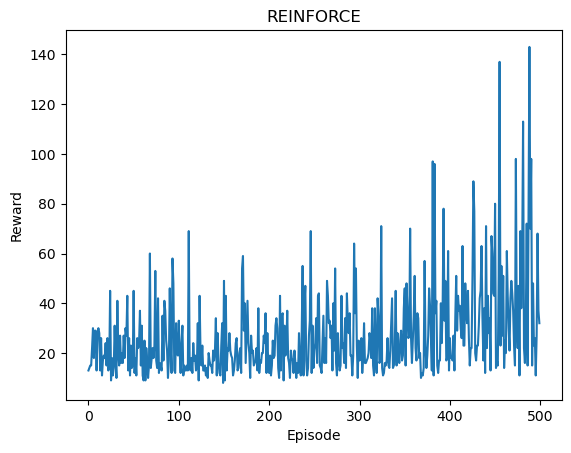

In [13]:
# Implementation of REINFORCE for the Cartpole environment

ENV="CartPole-v1"

N_EPISODES=500

# set the env
env=gym.make(ENV) # env to import
env.reset() # reset to env

Agent = REINFORCE(env)

Agent.train(N_EPISODES)

#plot the rewards
import matplotlib.pyplot as plt
plt.plot(Agent.total_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('REINFORCE')
plt.show()

# save the model
Agent.save_model('saved_models\REINFORCE.h5')


           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           4
               Dense   XXXXX -------------------       320     6.9%
                relu   #####          64
               Dense   XXXXX -------------------      4160    90.2%
                relu   #####          64
               Dense   XXXXX -------------------       130     2.8%
             softmax   #####           2

 episode =  0 reward =  14.0

 episode =  1 reward =  11.0

 episode =  2 reward =  21.0

 episode =  3 reward =  13.0

 episode =  4 reward =  52.0

 episode =  5 reward =  38.0

 episode =  6 reward =  16.0

 episode =  7 reward =  11.0

 episode =  8 reward =  15.0

 episode =  9 reward =  25.0

 episode =  10 reward =  17.0

 episode =  11 reward =  46.0

 episode =  12 reward =  13.0

 episode =  13 reward =  17.0

 episode =  14 reward =  18.0

 episode =  15 reward =  21.0

 episode =  16 reward =  16.0

 episode =  17 reward =  56.0

 episode 

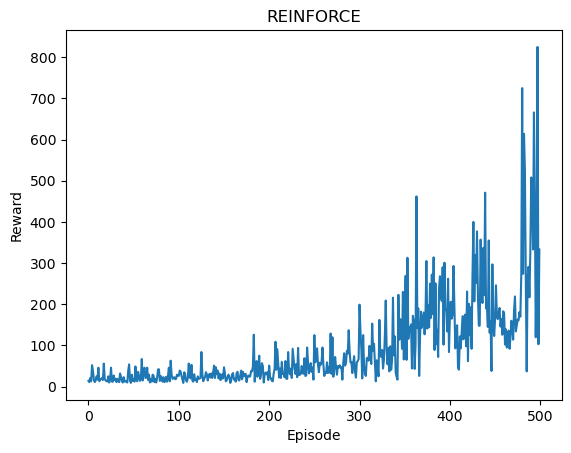

In [15]:
# Implementation of REINFORCE for the Cartpole environment

ENV="CartPole-v1"

N_EPISODES=500

# set the env
env=gym.make(ENV) # env to import
env.reset() # reset to env

Agent = REINFORCE(env)

Agent.train(N_EPISODES)

#plot the rewards
import matplotlib.pyplot as plt
plt.plot(Agent.total_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('REINFORCE')
plt.show()

# save the model
Agent.save_model('saved_models\REINFORCE.h5')


## 2. Lunarlander environment

- Solve the OpenAI Gym Lunarlander environment with REINFORCE. 
- Plot the reward history (learning curve). For each episode plot the cumulative reward, or even better: plot average cumulative reward over a certain number of episodes (for example 50 episodes).
- Compare the results to the ones of Deep Q-learning. Check the speed of learning, consistency of the results, etc.

In [3]:
# Implementation of REINFORCE for the Lunarlander environment 



## 3. CarRacing environment ---- OPTIONAL ----

- Solve the OpenAI Gym CarRacing environment with REINFORCE. 
- Plot the reward history (learning curve). For each episode plot the cumulative reward, or even better: plot average cumulative reward over a certain number of episodes (for example 50 episodes).
- Compare the results to the ones of Deep Q-learning. Check the speed of learning, consistency of the results, etc.